В ходе учебной практики в компании Webgames мной решалась задача предсказания LTV (lifetime value, пожизненной стоимости клиента) на основе предоставленных пользовательских данных приложения для Android. Расчёт данной метрики для пользователя позволяет предсказать, какую прибыль от него следует ожидать, и соответствующим способом модифицировать возможные предложения по скидкам для внутриигровых покупок. Использовались файлы со следующими данными:


```practice_dau_and``` - ежедневные сообщения с устройства игрока
* id - идентификатор игрока;
* сountry - страна;
* number_of_pgr - количество PGR-сообщений (их шлет устройство во время игры);
* actdate - дата события.

```practice_pact_and``` - агрегированные данные о деятельности игрока в этот день
* id - идентификатор игрока;
* actdate - дата события;
* regdate - дата регистрации игрока;
* clusters_ml_ended - сколько кластеров (кластеры состоят из квестов) основной сюжетной линии прошел игрок;
* revenue - прибыль с игрока;
* transactions - количество платежей;
* quests_end - сколько побочных квестов прошел игрок;
* m_quests_end - сколько квестов основной сюжетной линии прошел игрок;
* crystals_value_spend - сколько кристаллов (в определенной нормировке) потратил игрок;
* store_enters - сколько раз игрок зашел в магазин.

Для оценки моделей использовались следующие метрики:
* RMSE — Root Mean Squared Error
* MAE — Mean Absolute Error

Также качество предсказания справнивалось следующим образом: из всей выборки выделялась в тестовую информация по пользователям, зарегистрировавшимся с 13 по 19 февраля 2017 года (данные по игрокам, зарегистрировавшимся до этого, соответственно, являлись обучающей выборкой), затем все предсказания модели по каждому из пользователей и дней недели суммировались и сравнивались с действительными показателями.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import product
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
import gc
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['savefig.dpi']=400

Для начала загрузим данные и удалим строки-дубликаты из таблицы ```practice_dau_and``` (из двух записей о пользователе в один и тот же день выбиралась запись с большим числом PGR-сообщений), а также удалили из таблицы ```practice_pact_and``` столбцы ```crystals_value_spend``` и ```store_enters```, так как они содержат только 0 и изменили дату регистрации для каждого пользователя на наиболее раннюю. Для уменьшения занимаемой памяти категориальные признаки ```country``` и ```id``` преобразовывались в целочисленные с помощью ```LabelEncoder```.

In [2]:
dau=pd.read_csv("practice_dau_and.csv",sep="|",header=None,engine="c",names=["id","country","number_of_pgr","actdate"],
                dtype={"number_of_pgr":"int16"},
                parse_dates=[3],na_filter=False).sort_values(by=["id","actdate","number_of_pgr"]).drop_duplicates(
    subset=["id","actdate"],keep="last")
pact=pd.read_csv("practice_pact_and.csv",sep="|",header=None,engine="c",names=
                ["id","actdate","regdate","clusters_ml_ended","revenue","transactions","quests_end","m_quests_end",
                "crystals_value_spend","store_enters"],usecols=["id","actdate","regdate","clusters_ml_ended",
                "revenue","transactions","quests_end","m_quests_end"],dtype={"clusters_ml_ended":"int8",
                "revenue":"float32","transactions":"int8","quests_end":"int16","m_quests_end":"int16"},
                 parse_dates=[1,2])
pact=pact.drop("regdate",axis=1).join(pact.groupby("id").regdate.min().to_frame(),on="id")
pact=pd.merge(dau,pact,on=["id","actdate"],copy=False)
lenc_cntr=LabelEncoder()
lenc_id=LabelEncoder()
pact.country=lenc_cntr.fit_transform(pact.country.values).astype("uint8")
pact.id=lenc_cntr.fit_transform(pact.id.values).astype("uint32")
del dau

Всё преобразование данных для деления на обучающую и тестовую выборки в вид, в котором одному пользователю сопоставляется вектор признаков
описано в функции split_data:
    
* ```pact``` — исходная таблица с объединёнными данными из двух источников, прошедшими предварительную очистку
* ```days_obs``` — число дней, по наблюдению за которые проводились предсказания
* ```days_pred``` — число дней, по наблюдению за которые рассчитывалась прибыль с пользователя
* ```threshold``` — порог, по превышению которого прибыль (как за конкретный день, так и по окончанию периода наблюдений) становилась равной ```threshold```


In [3]:
def split_data(pact,days_obs,days_pred,testweek=False,threshold=1000):
    y=pact[(pact.actdate-pact.regdate)<=timedelta(days=days_pred-1)].groupby("id").revenue.sum().to_frame()
    y.loc[y.revenue>threshold,"revenue"]=threshold
    pact_train=pact[(pact.actdate-pact.regdate)<=timedelta(days=days_obs-1)].copy()
    pact_train.loc[pact_train.revenue>threshold,"revenue"]=threshold
    pact_train["day"]=((pact_train["actdate"]-pact_train["regdate"])/np.timedelta64(1, 'D')).astype("int8")
    pact_train=pact_train.set_index(["id","day"]).reindex(pd.MultiIndex.from_product([pact_train["id"].unique(), range(days_obs)], names=["id", "day"]))
    pact_train.regdate.fillna(method="ffill",inplace=True)
    pact_train.country.fillna(method="ffill",inplace=True)
    pact_train.actdate=pd.to_timedelta(pact_train.index.get_level_values(level=1),"d")+pact_train.regdate
    pact_train.fillna(0,inplace=True)
    pact_train["regmonth"]=pact_train.regdate.dt.month
    pact_train["regday"]=pact_train.regdate.dt.day
    pact_train["actmonth"]=pact_train.actdate.dt.month
    pact_train["actday"]=pact_train.actdate.dt.day
    pact_train=pact_train.drop(["regdate","actdate"],axis=1).unstack().drop(
        [col for col in product(["regmonth","regday","country"],range(1,days_obs))],axis=1)
    pact_train[[("country",0)]+[col for col in product(["transactions","actmonth","actday"],range(days_obs))]]=pact_train[[
    ("country",0)]+[col for col in product(["transactions","actmonth","actday"],range(days_obs))]].astype("uint8")
    pact_train[[col for col in product(["clusters_ml_ended"],range(days_obs))]]=pact_train[
        [col for col in product(["clusters_ml_ended"],range(days_obs))]].astype("int8")
    pact_train[[col for col in product(["revenue"],range(days_obs))]]=pact_train[
        [col for col in product(["revenue"],range(days_obs))]].astype("float32")
    pact_train[[col for col in product(["number_of_pgr","quests_end","m_quests_end"],range(days_obs))]]=pact_train[[
        col for col in product(["number_of_pgr","quests_end","m_quests_end"],range(days_obs))]].astype("int16")
    pact_train.columns=["".join(map(str,col)) for col in pact_train.columns]
    pact_train.rename(columns={"regmonth0":"regmonth","regday0":"regday","country0":"country"},inplace=True)
    pact_train.index.name=None
    cleaned=pd.merge(pact_train,y,left_index=True,right_index=True)
    if testweek:
        train=cleaned[(cleaned.regmonth==1)|((cleaned.regmonth==2)&(cleaned.regday<13))]
        test=[cleaned[(cleaned.regmonth==2)&(cleaned.regday==day)] for day in range(13,20)]
        return train,test
    else:
        train=cleaned[(cleaned.regmonth<3)|((cleaned.regmonth==3)&(cleaned.regday<17))]
        test=cleaned[~((cleaned.regmonth<3)|((cleaned.regmonth==3)&(cleaned.regday<17)))]
        return train,test

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from lightgbm import LGBMRegressor, early_stopping
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
import lightgbm
import sklearn
from multiprocessing import Pool, cpu_count
from functools import partial

In [6]:
# train,test=split_data(pact,7,30)
# regr1=LGBMRegressor(n_estimators=58)
# regr1.fit(train.drop("revenue",axis=1),train.revenue)
# print(r2_score(test.revenue,regr1.predict(test.drop("revenue",axis=1))),
#      mean_squared_error(test.revenue,regr1.predict(test.drop("revenue",axis=1))),
#      np.sqrt(mean_squared_error(test.revenue,regr1.predict(test.drop("revenue",axis=1)))),
#      mean_absolute_error(test.revenue,regr1.predict(test.drop("revenue",axis=1))))
# plot_importance(regr1)

In [7]:

# print(true_sum,regr1.predict(oneday.drop("revenue",axis=1)).sum())

В процессе сравнивались следующие модели: LightGBM, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, ElasticNetCV (линейная модель с L1- и L2-регуляризацией)

In [5]:
def fit(regr,X,y):
    return regr.fit(X,y)

def get_models_scores(pact,days_obs,days_pred):
    print(str(days_obs)+"-"+str(days_pred))
    train,test=split_data(pact,days_obs,days_pred)
    regr1=LGBMRegressor(n_estimators=100)
    regr2=ElasticNet()
    regr3=RandomForestRegressor()
    regr4=ExtraTreesRegressor()
    regr5=GradientBoostingRegressor(subsample=0.85)
    x_train,y_train=train.drop("revenue",axis=1),train.revenue
    x_test,y_test=test.drop("revenue",axis=1),test.revenue
    regr1.fit(x_train,y_train)
    with Pool(processes=cpu_count()) as p:
        regr2,regr3,regr4,regr5=p.map(partial(fit,X=x_train,y=y_train),[regr2,regr3,regr4,regr5])
    oneday=test[(test.regmonth==5)&(test.regday==1)]
    true_sum=oneday.revenue.sum()
    mse_results=[mean_squared_error(y_test,regr.predict(x_test)) for regr in [regr1,regr2,regr3,regr4,regr5]]
    best=np.argmin(mse_results)
    if best==0:
        lightgbm.plot_importance(regr1,max_num_features=10)
    elif best==2:
        sklearn.ensemble.plot_importance(regr2)
    elif best==3:
        sklearn.ensemble.plot_importance(regr3)
    elif best==4:
        sklearn.ensemble.plot_importance(regr4)
    plt.show()
    mae_results=[mean_absolute_error(y_test,regr.predict(x_test)) for regr in [regr1,regr2,regr3,regr4,regr5]]
    oneday_results=[regr.predict(oneday.drop("revenue",axis=1)).sum() for regr in [regr1,regr2,regr3,regr4,regr5]]
    return [pd.DataFrame(np.sqrt(np.array(mse_results+[np.mean(np.square(test.revenue))])).reshape(1,6),
            index=[str(days_obs)+"-"+str(days_pred)],columns=["LightGBM","ElasticNet","RandomForestRegressor",
            "ExtraTreesRegressor","GradientBoostingRegressor","RMS of revenues"]),
            pd.DataFrame(np.array(mae_results+[np.mean(test.revenue)]).reshape(1,6),index=[
            str(days_obs)+"-"+str(days_pred)],columns=["LightGBM","ElasticNet","RandomForestRegressor",
            "ExtraTreesRegressor","GradientBoostingRegressor","Mean of revenues"]),
            pd.DataFrame(np.array(oneday_results+[true_sum]).reshape(1,6),index=[
            str(days_obs)+"-"+str(days_pred)],columns=["LightGBM","ElasticNet","RandomForestRegressor",
            "ExtraTreesRegressor","GradientBoostingRegressor","True sum"])
           ]

def get_week_results(pact,days_obs,days_pred):
    print(str(days_obs)+"-"+str(days_pred))
    train,test=split_data(pact,days_obs,days_pred,testweek=True)
    regr1=LGBMRegressor(n_estimators=100)
    regr2=ElasticNet()
    regr3=RandomForestRegressor()
    regr4=ExtraTreesRegressor()
    regr5=GradientBoostingRegressor(subsample=0.85)
    x_train,y_train=train.drop("revenue",axis=1),train.revenue
    regr1.fit(x_train,y_train)
    with Pool(processes=cpu_count()) as p:
        regr2,regr3,regr4,regr5=p.map(partial(fit,X=x_train,y=y_train),[regr2,regr3,regr4,regr5])
    return [pd.DataFrame(np.array([regr.predict(test[day].drop("revenue",axis=1)).sum() for regr in [regr1,regr2,regr3,regr4,
            regr5]]+[test[day].revenue.sum()]).reshape(1,6),index=[str(days_obs)+"-"+str(days_pred)],columns=["LightGBM",
            "ElasticNet","RandomForestRegressor","ExtraTreesRegressor","GradientBoostingRegressor","True sum"]
                        ) for day in range(7)]

In [ ]:
results_list=[get_models_scores(pact,obs,pred) for obs,pred in product([3,7,15],[15,30,60,100])]

In [ ]:
pd.concat([item[0] for item in results_list])

In [ ]:
pd.concat([item[1] for item in results_list])

In [ ]:
pd.concat([item[2] for item in results_list])

In [ ]:
week_result_list=[get_week_results(pact,obs,pred) for obs,pred in product([3,7,15],[15,30,60,100])]

In [ ]:
pd.concat([item[0] for item in week_result_list])

In [ ]:
pd.concat([item[1] for item in week_result_list])

In [ ]:
pd.concat([item[2] for item in week_result_list])

In [ ]:
pd.concat([item[3] for item in week_result_list])

In [ ]:
pd.concat([item[4] for item in week_result_list])

In [ ]:
pd.concat([item[5] for item in week_result_list])

In [ ]:
pd.concat([item[6] for item in week_result_list])

In [ ]:
def eval_model(params={},threshold=1000):
    train,test=split_data(pact,3,30,threshold=threshold)
    regr=LGBMRegressor(**params,n_estimators=100)
    x_train,y_train=train.drop("revenue",axis=1),train.revenue
    x_test,y_test=test.drop("revenue",axis=1),test.revenue
    regr.fit(x_train,y_train)
    return(np.sqrt(mean_squared_error(y_test,regr.predict(x_test))),mean_absolute_error(y_test,regr.predict(x_test)))

In [ ]:
for thresh in range(1000,50000,1000):
    print(eval_model(threshold=thresh))

In [ ]:
df=pd.DataFrame(list(map(lambda x: x.strip("()").split(","),l)),index=range(1000,40000,1000),columns=["RMSE","MAE"])

In [59]:
from hyperopt import Trials, fmin, tpe, space_eval, hp, STATUS_OK
params={
    'n_estimators' : 10000,
    'max_depth':hp.quniform('max_depth',-1,12,1),
    'num_leaves':hp.quniform('num_leaves',10,1023,1),
    'min_child_weight':hp.uniform('min_child_weight',1e-4,20),
    'subsample':hp.uniform('subsample',0.7,1),
    'colsample_bytree':hp.uniform('colsample_bytree',0.7,1),
    'reg_alpha':hp.uniform('reg_alpha',0,5),
    'reg_lambda':hp.uniform('reg_lambda',0,1),
    'min_data_in_leaf':hp.quniform('min_data_in_leaf',1,5000,1),
    'max_bin_pow':hp.quniform('max_bin_pow',4,10,1),
    'learning_rate':0.1,
}

def func(params):
    params['max_depth']=int(params['max_depth'])
    params['n_estimators']=int(params['n_estimators'])
    params['num_leaves']=int(params['num_leaves'])
    params['min_data_in_leaf']=int(params['min_data_in_leaf'])
    params['max_bin']=int(2**params['max_bin_pow']-1)
    del params['max_bin_pow']
    print(params)
    regr=LGBMRegressor(**params,seed=123456)
    train,test=split_data(pact,3,30)
    x_train,y_train=train.drop("revenue",axis=1),train.revenue
    x_test,y_test=test.drop("revenue",axis=1),test.revenue
    regr.fit(x_train,y_train,eval_set=[(x_test,y_test)],callbacks=[early_stopping(25,verbose=False)],verbose=False)
    sc1=np.sqrt(mean_squared_error(y_test,regr.predict(x_test)))
    print("3-30:",sc1)
    regr=LGBMRegressor(**params,seed=123456)
    train,test=split_data(pact,7,60)
    x_train,y_train=train.drop("revenue",axis=1),train.revenue
    x_test,y_test=test.drop("revenue",axis=1),test.revenue
    regr.fit(x_train,y_train,eval_set=[(x_test,y_test)],callbacks=[early_stopping(25,verbose=False)],verbose=False)
    sc2=np.sqrt(mean_squared_error(y_test,regr.predict(x_test)))
    print("7-60:",sc2)
    regr=LGBMRegressor(**params,seed=123456)
    train,test=split_data(pact,7,100)
    x_train,y_train=train.drop("revenue",axis=1),train.revenue
    x_test,y_test=test.drop("revenue",axis=1),test.revenue
    regr.fit(x_train,y_train,eval_set=[(x_test,y_test)],callbacks=[early_stopping(25,verbose=False)],verbose=False)
    sc3=np.sqrt(mean_squared_error(y_test,regr.predict(x_test)))
    print("7-100:",sc3)
    regr=LGBMRegressor(**params,seed=123456)
    train,test=split_data(pact,15,100)
    x_train,y_train=train.drop("revenue",axis=1),train.revenue
    x_test,y_test=test.drop("revenue",axis=1),test.revenue
    regr.fit(x_train,y_train,eval_set=[(x_test,y_test)],callbacks=[early_stopping(25,verbose=False)],verbose=False)
    sc4=np.sqrt(mean_squared_error(y_test,regr.predict(x_test)))
    print("15-100:",sc4)
    gc.collect()
#     return {'loss':sc3,'status':STATUS_OK}
    return {'loss':np.mean([sc1,sc2,sc3,sc4]),'status':STATUS_OK}

In [11]:
func({'n_estimators':100,'max_depth':-1,'num_leaves':31})

{'n_estimators': 100, 'max_depth': -1, 'num_leaves': 31}
3-30: 82.7927021512
7-60: 62.2045558415
7-100: 62.4055120637
15-100: 40.5791995584


{'loss': 61.995492403689852, 'status': 'ok'}

In [14]:
func({'n_estimators':500,'max_depth':-1,'num_leaves':20,'learning_rate':0.01})

{'n_estimators': 500, 'learning_rate': 0.01, 'max_depth': -1, 'num_leaves': 20}
3-30: 82.8143388377
7-60: 62.1212960307
7-100: 62.3287794874
15-100: 40.4805326112


{'loss': 61.936236741746882, 'status': 'ok'}

In [61]:
trials=Trials()

In [ ]:
best=fmin(func,params,algo=tpe.suggest,trials=trials,max_evals=200)

{'reg_lambda': 0.049357534269926284, 'max_bin': 63, 'colsample_bytree': 0.7123917503834754, 'reg_alpha': 4.988415177157608, 'min_data_in_leaf': 2727, 'learning_rate': 0.1, 'subsample': 0.9387563654107016, 'min_child_weight': 2.5214094116051444, 'n_estimators': 10000, 'max_depth': 9, 'num_leaves': 629}
3-30: 83.0034560233
7-60: 76.6454796791
7-100: 76.7249098122
15-100: 75.1792079619
{'reg_lambda': 0.07906626849883269, 'max_bin': 511, 'colsample_bytree': 0.8843148047636806, 'reg_alpha': 2.6229240183163616, 'min_data_in_leaf': 492, 'learning_rate': 0.1, 'subsample': 0.8833994448471818, 'min_child_weight': 19.78333222600199, 'n_estimators': 10000, 'max_depth': 3, 'num_leaves': 328}
3-30: 82.8293638735
7-60: 65.2160727862
7-100: 65.6283722888
15-100: 54.0290011554
{'reg_lambda': 0.6332525828227766, 'max_bin': 31, 'colsample_bytree': 0.9440981429929072, 'reg_alpha': 0.23031252602132402, 'min_data_in_leaf': 17, 'learning_rate': 0.1, 'subsample': 0.7906661477290673, 'min_child_weight': 7.8347

In [63]:
best=space_eval(params,{key:value[0] for key,value in trials.best_trial['misc']['vals'].items() if len(value)>0})

In [65]:
func(best)

{'reg_lambda': 0.3044910889111851, 'max_bin': 63, 'colsample_bytree': 0.7544918024653926, 'reg_alpha': 2.656044279362783, 'min_data_in_leaf': 24, 'learning_rate': 0.1, 'subsample': 0.9105773816276077, 'min_child_weight': 15.276244888375265, 'n_estimators': 10000, 'max_depth': 12, 'num_leaves': 328}
3-30: 82.8647166718
7-60: 62.1020812518
7-100: 62.3354566387
15-100: 41.0607493393


{'loss': 62.09075097538927, 'status': 'ok'}

In [64]:
best

{'colsample_bytree': 0.7544918024653926,
 'learning_rate': 0.1,
 'max_bin_pow': 6.0,
 'max_depth': 12.0,
 'min_child_weight': 15.276244888375265,
 'min_data_in_leaf': 24.0,
 'n_estimators': 10000,
 'num_leaves': 328.0,
 'reg_alpha': 2.656044279362783,
 'reg_lambda': 0.3044910889111851,
 'subsample': 0.9105773816276077}

In [43]:
days_pred=60
days_obs=7
threshold=1000
y=pact[(pact.actdate-pact.regdate)<=timedelta(days=days_pred-1)].groupby("id").revenue.sum().to_frame()
y.loc[y.revenue>threshold,"revenue"]=threshold
pact_train=pact[(pact.actdate-pact.regdate)<=timedelta(days=days_obs-1)].copy()
pact_train.loc[pact_train.revenue>threshold,"revenue"]=threshold
pact_train["day"]=((pact_train["actdate"]-pact_train["regdate"])/np.timedelta64(1, 'D')).astype("int8")
pact_train=pact_train.set_index(["id","day"]).reindex(pd.MultiIndex.from_product([pact_train["id"].unique(), range(days_obs)], names=["id", "day"]))
pact_train.regdate.fillna(method="ffill",inplace=True)
pact_train.country.fillna(method="ffill",inplace=True)
pact_train.actdate=pd.to_timedelta(pact_train.index.get_level_values(level=1),"d")+pact_train.regdate
pact_train.fillna(0,inplace=True)
pact_train["regmonth"]=pact_train.regdate.dt.month
pact_train["regday"]=pact_train.regdate.dt.day
pact_train["actmonth"]=pact_train.actdate.dt.month
pact_train["actday"]=pact_train.actdate.dt.day
pact_train=pact_train.drop(["regdate","actdate"],axis=1).unstack().drop(
    [col for col in product(["regmonth","regday","country"],range(1,days_obs))],axis=1)
pact_train[[("country",0)]+[col for col in product(["transactions","actmonth","actday"],range(days_obs))]]=pact_train[[
("country",0)]+[col for col in product(["transactions","actmonth","actday"],range(days_obs))]].astype("uint8")
pact_train[[col for col in product(["clusters_ml_ended"],range(days_obs))]]=pact_train[
    [col for col in product(["clusters_ml_ended"],range(days_obs))]].astype("int8")
pact_train[[col for col in product(["revenue"],range(days_obs))]]=pact_train[
    [col for col in product(["revenue"],range(days_obs))]].astype("float32")
pact_train[[col for col in product(["number_of_pgr","quests_end","m_quests_end"],range(days_obs))]]=pact_train[[
    col for col in product(["number_of_pgr","quests_end","m_quests_end"],range(days_obs))]].astype("int16")
pact_train.columns=["".join(map(str,col)) for col in pact_train.columns]

pact_train.rename(columns={"regmonth0":"regmonth","regday0":"regday","country0":"country"},inplace=True)
pact_train.index.name=None

In [44]:
cleaned=pd.merge(pact_train,y,left_index=True,right_index=True)
train=cleaned[(cleaned.regmonth<3)|((cleaned.regmonth==3)&(cleaned.regday<17))]
test=cleaned[~((cleaned.regmonth<3)|((cleaned.regmonth==3)&(cleaned.regday<17)))]

In [45]:
regr=LGBMRegressor(n_estimators=100,seed=123)
regr.fit(train.drop("revenue",axis=1),train.revenue)
mean_squared_error(test.revenue,regr.predict(test.drop("revenue",axis=1)))

3864.3174660969516

In [49]:
pact_train["rev_min"]=np.min(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
pact_train["rev_max"]=np.max(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
pact_train["rev_mean"]=np.mean(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
pact_train["rev_median"]=np.median(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
pact_train["rev_std"]=np.std(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
pact_train["rev_nonzero"]=np.count_nonzero(pact_train[["revenue"+str(i) for i in range(days_obs)]],axis=1)
pact_train["frac_zero"]=1-pact_train["rev_nonzero"]/days_obs

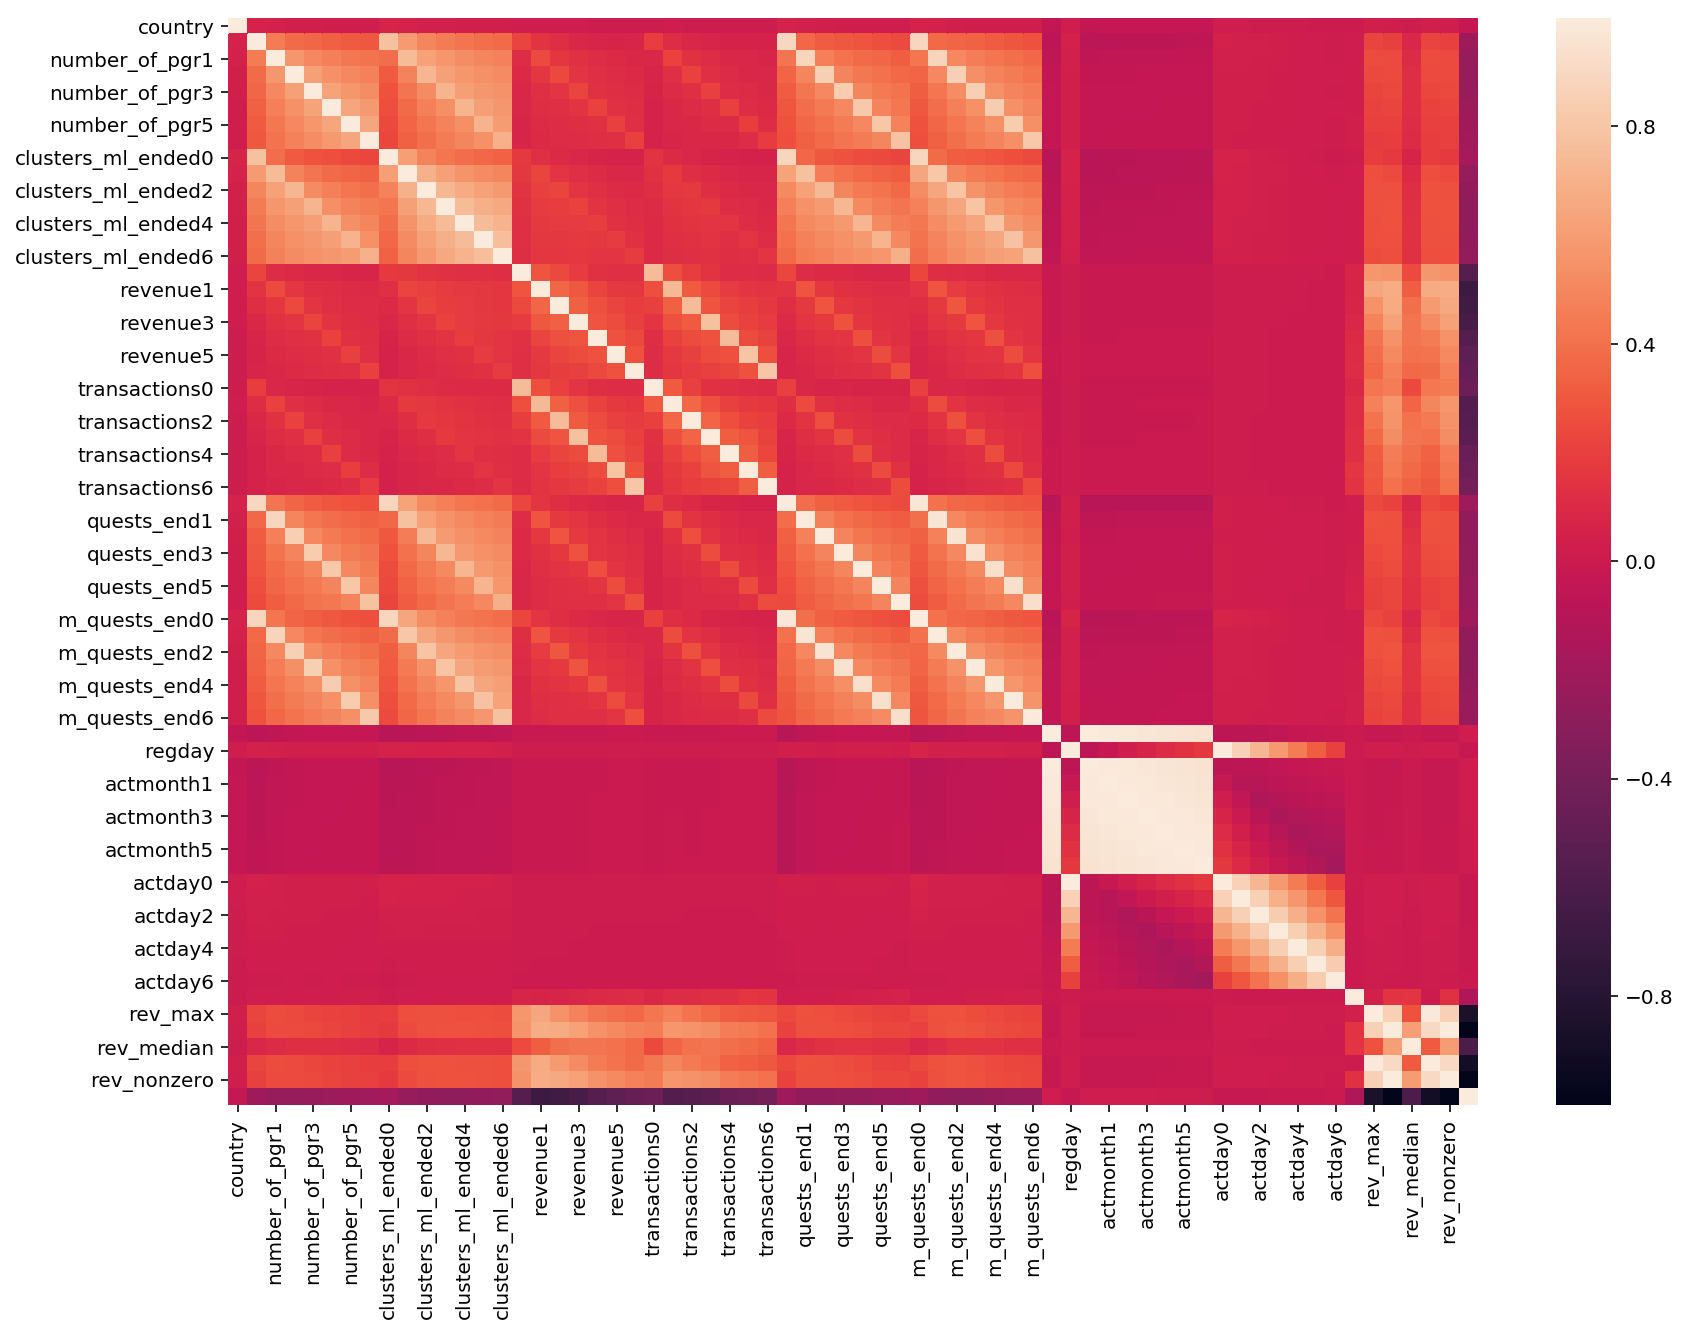

In [50]:
sns.heatmap(pact_train.corr())

In [51]:
cleaned=pd.merge(pact_train,y,left_index=True,right_index=True)
train=cleaned[(cleaned.regmonth<3)|((cleaned.regmonth==3)&(cleaned.regday<17))]
test=cleaned[~((cleaned.regmonth<3)|((cleaned.regmonth==3)&(cleaned.regday<17)))]

Ошибка до отбора признаков:

In [52]:
regr=LGBMRegressor(n_estimators=100,seed=123)
regr.fit(train.drop("revenue",axis=1),train.revenue)
mean_squared_error(test.revenue,regr.predict(test.drop("revenue",axis=1)))

3860.0216706707561

In [54]:
from mlxtend.feature_selection import SequentialFeatureSelector
sfs=SequentialFeatureSelector(regr,k_features=(50,66),forward=False,floating=True,scoring="neg_mean_squared_error",
                              verbose=2)

In [ ]:
sfs.fit(train.drop("revenue",axis=1).values,train.revenue.values)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed: 36.3min finished

[2017-07-25 21:26:35] Features: 65/50 -- score: -2700.30994268[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.1s remaining:    0.0s


Ошибка после отбора признаков:

In [62]:
regr=LGBMRegressor(n_estimators=100,seed=123)
regr.fit(sfs.transform(train.drop("revenue",axis=1).values),train.revenue)
mean_squared_error(test.revenue,regr.predict(sfs.transform(test.drop("revenue",axis=1).values)))

3860.2785832836917